In [1]:
pip install -q pandas_market_calendars

Note: you may need to restart the kernel to use updated packages.


In [3]:
import yfinance as yf 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pandas as pd
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt

In [4]:
ticker = "WBC.AX"  # NAB stock ticker for Australian market
data = yf.download(ticker, period="3mo", interval="1d")  # Fetch data for the last 3 months
closing_prices = data['Close'].values.reshape(-1, 1)[-50:]  # Extract last 50 closing prices
dates = data.index[-50:]  # Fetching corresponding dates 

[*********************100%***********************]  1 of 1 completed


In [5]:
scaler = MinMaxScaler(feature_range=(0,1)) 
data_normalized = scaler.fit_transform(closing_prices) 

In [6]:
def create_sequences(data,time_step=1):
    X,Y = [],[] 
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0]) 
        Y.append(data[i + time_step, 0]) 
    return np.array(X),np.array(Y) 
time_step = 20 
X,Y = create_sequences(data_normalized,time_step) 
X = X[-20:] 
Y = Y[-20:] 
X = X.reshape(X.shape[0],X.shape[1],1)

In [7]:
model = Sequential() 
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1))) 
model.add(LSTM(50,return_sequences=False)) 
model.add(Dense(1)) 
model.compile(optimizer='adam',loss='mean_squared_error') 
model.fit(X,Y,epochs=100,batch_size=1) 


Epoch 1/100


c:\Users\石天辰\.conda\envs\pytorch\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2101
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088    
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0135
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046
Epoch 16/100

In [8]:
predicted_prices = [] 
current_sequence = data_normalized[-time_step:] 
for _ in range(10):
    current_sequence = current_sequence.reshape(1,time_step,1) 
    predicted_value = model.predict(current_sequence) 
    predicted_prices.append(predicted_value[0][0]) 
    current_sequence =np.append(current_sequence[0][1:],predicted_value) 
    current_sequence = current_sequence.reshape(time_step,1) 
predicted_prices = np.array(predicted_prices).reshape(-1,1) 
predicted_prices = scaler.inverse_transform(predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [10]:
aus_cal = mcal.get_calendar('ASX') 
schedule = aus_cal.schedule(start_date=dates[-1],end_date=dates[-1] + pd.DateOffset(days=20)) 
next_10_trading_dates = schedule.index[1:11] 
closing_prices_flat = closing_prices.flatten() 
closing_prices_series = pd.Series(closing_prices_flat) 
dates_series = pd.to_datetime(dates) 

In [11]:
support = closing_prices_series.rolling(window=10).min().iloc[-1] 
resistance = closing_prices_series.rolling(window=10).max().iloc[-1]

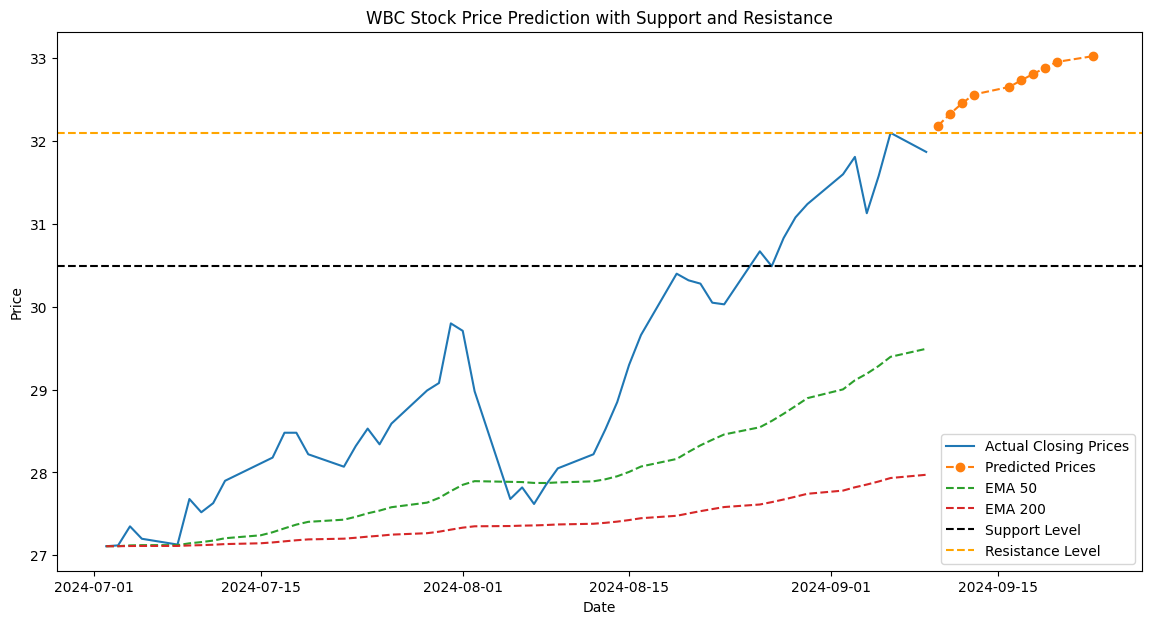

In [12]:
plt.figure(figsize=(14,7)) 
plt.plot(dates,closing_prices,label='Actual Closing Prices') 
plt.plot(next_10_trading_dates,predicted_prices,label="Predicted Prices",linestyle='dashed',marker='o') 
ema_50 = closing_prices_series.ewm(span=50,adjust=False).mean() 
ema_200 = closing_prices_series.ewm(span=200,adjust=False).mean() 
plt.plot(dates_series,ema_50,label='EMA 50',linestyle='--') 
plt.plot(dates_series,ema_200,label='EMA 200',linestyle='--') 

# Plot Support and Resistance lines
plt.axhline(y=support, color='black', linestyle='--', label="Support Level")
plt.axhline(y=resistance, color='orange', linestyle='--', label="Resistance Level")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"WBC Stock Price Prediction with Support and Resistance")
plt.legend()

plt.show()


In [13]:
true_values_last_10 = data['Close'].values[-10:] 
predicted_values_last_10 = predicted_prices.flatten()[-10:] 

mae = np.mean(np.abs(true_values_last_10 - predicted_values_last_10)) 
rmse = np.sqrt(np.mean((true_values_last_10 - predicted_values_last_10) ** 2)) 
print("\nModel Evaluation:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

print("\nLast 10 Trading Day Share Prices:")
print(data['Close'].tail(10))

print("\nLast 10 Predicted Prices:")
for date, price in zip(next_10_trading_dates, predicted_prices[-10:]):
    print(f"{date.date()}: {price[0]}")

print("\nPredicted Next 10 Trading Day Share Prices:")
for date, price in zip(next_10_trading_dates, predicted_prices):
    print(f"{date.date()}: {price[0]}")



Model Evaluation:
Mean Absolute Error (MAE): 1.2869882583618164
Root Mean Squared Error (RMSE): 1.3163736551039185

Last 10 Trading Day Share Prices:
Date
2024-08-27    30.490000
2024-08-28    30.830000
2024-08-29    31.080000
2024-08-30    31.240000
2024-09-02    31.600000
2024-09-03    31.809999
2024-09-04    31.129999
2024-09-05    31.580000
2024-09-06    32.099998
2024-09-09    31.870001
Name: Close, dtype: float64

Last 10 Predicted Prices:
2024-09-10: 32.1873779296875
2024-09-11: 32.328025817871094
2024-09-12: 32.45472717285156
2024-09-13: 32.56296157836914
2024-09-16: 32.654640197753906
2024-09-17: 32.73516082763672
2024-09-18: 32.81084060668945
2024-09-19: 32.88444519042969
2024-09-20: 32.95642852783203
2024-09-23: 33.025272369384766

Predicted Next 10 Trading Day Share Prices:
2024-09-10: 32.1873779296875
2024-09-11: 32.328025817871094
2024-09-12: 32.45472717285156
2024-09-13: 32.56296157836914
2024-09-16: 32.654640197753906
2024-09-17: 32.73516082763672
2024-09-18: 32.810840